**Тестовое задание для поступления на кафедру Системного программирования**

Задание состоит из нескольких этапов:
1.   Реализация свёрточной нейронной сети на основе библиотеки PyTorch, используя датасет Cifar-10;
2.   Реализация оптимизатора Adam на основе статьи "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION";
3.   Обучение нейронной сети, используя написанный оптимизатор Adam;
4.   Проведение обучения, используя оптимизатор SGD из библиотеки PyTorch;
5.   Анализ полученных результатов обучений и представление результатов на графиках, используя библиотеку Matplotlib.


Для начала подключаем необходимые библиотеки и импортируем необходимые функции из них для удобства:

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import sys
#from adam import Adam

Теперь реализуем 2 важнейшие функции: обучение и тестирование модели. Здесь использовался стандартный алгоритм обучения: обнуление градиентов, подсчёт результата работы нейронной сети на входных данных, подсчёт функции потерь и проведение шага оптимизатора:

In [19]:
#функция-обучения нейронной сети
def train_loop(data, model, func_loss, optimizer, f = sys.stdout):
    size = len(data.dataset)

    model.train()
    running_loss = 0.0
    for batch, (inputs, labels) in enumerate(data, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = func_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch + 1) % 2500 == 0:
            print(f"loss: {running_loss / 2000:>7f}  [{(batch + 1) * batch_size:>5d}/{size:>5d}]", file = f)
            running_loss = 0.0


Теперь реализуем функцию проверки точности нейронной сети на тестовых данных:

In [20]:
#функция-тестирование нейронной сети
def test_loop(data, model, func_loss, f):
    correct = 0
    total = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for (inputs, labels) in data:
            outputs = model(inputs)
            test_loss += func_loss(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%, loss: %.7f' % (100 * correct / total, test_loss / (total / batch_size)), file = f)
    return (100 * correct / total), (test_loss / (total / batch_size))

Укажем наши гиперпараметры, которые удобно менять для увеличения точности нейронной сети:

In [21]:
#выбор гиперпараметров
batch_size = 4
learn_rate = 1e-3
epoch = 10
momentum = 0.9

Теперь проведем загрузку датасета с помощью функций библиотеки torchvision. После разобъём наши датасеты по партиям:

In [22]:
#Преобразование данных: перевод в тензор из PyTorch и нормализация
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#загрузка датасета
data_train = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
data_test = datasets.CIFAR10(root = "./data", train = False, download = False, transform = transform)
#разбитие данных на партии
dataload_train = DataLoader(data_train, batch_size = batch_size, shuffle = True)
dataload_test = DataLoader(data_test, batch_size = batch_size, shuffle = True)

Files already downloaded and verified


Настало время написать класс устройства нашей нейронной сети. Здесь мы инициализируем нейронную сеть, состоящую из 5 важных слоёв: 2 свёрточных и 3 линейных слоя:

In [23]:
#представление модели нейронной сети
class NeuralNetworks(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, input):
        output = self.network(input)
        return output

Здесь приведена реализация алгоритма из статьи "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION". Для удобства, реализация в виде класса, для более удобной инициализации переменных, а также класс наследуется от библиотечного torch.optim.Optimizer, чтобы использовать библиотечную реализацию функции zero_grad():

In [24]:
class Adam(optim.Optimizer):
    def __init__(self, param, alpha = 1e-3, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
        self.param = list(param)
        number_of_param = sum([par.numel() for par in self.param])
        self.t = 0
        self.m = [0] * number_of_param
        self.v = [0] * number_of_param
        defaults = dict(lr=alpha, betas=(beta1, beta2), eps=eps)
        super().__init__(self.param, defaults)
        # self.alpha = alpha
        # self.beta1 = beta1
        # self.beta2 = beta2
        # self.eps = eps

    def step(self):
        self.t += 1
        i = 0
        for group in self.param_groups:
          alpha, eps = group['lr'], group['eps']
          beta1, beta2 = group['betas']
          for par in group['params']:
            gt = par.grad.data
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * gt
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (gt ** 2)
            mt = self.m[i] / (1 - beta1 ** self.t)
            vt = self.v[i] / (1 - beta2 ** self.t)
            par.data = par.data - alpha * mt / (vt ** 0.5 + eps)
            i += 1

Теперь мы готовы объявить нашу нейронную сеть, а также функции потерь CrossEntropyLoss и наш оптимизатор. Для последующего сравнения оптимизаторов, создадим 2 модели с разными оптимизаторами:

In [25]:
#инициализация модели свёрточной нейронной сети, выбор функции потерь и оптимизитора
model_adam = NeuralNetworks()
model_sgd = NeuralNetworks()
loss_func = nn.CrossEntropyLoss()
optimizer_adam = Adam(model_adam.parameters(), alpha = learn_rate)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr = learn_rate, momentum = momentum)

Также создадим массивы для хранения данных тестирования для дальнейшей визуализации:

In [26]:
x = range(1, epoch + 1)
loss_mas = [[0] * epoch for i in range(2)]
accuracy_mas = [[0] * epoch for i in range(2)]

Также удобно было бы выводить данные обучения в разные файлы для разных моделей, поэтому зададим файлы - потоки вывода:

In [27]:
f_adam = open('output_adam.txt', 'w')
f_sgd = open('output_sgd.txt', 'w')

Далее запускаем цикл обучения, которая вызывает соответственно функции обучения модели и проверки результатов работы на тестовом датасете:

In [28]:
#цикл обучения и проверки результатов обучения нейронной сети
for ep in range(epoch):
    print(f"Epoch {ep + 1}")
    print(f"Epoch {ep + 1}\n-------------------------------", file = f_adam)
    print(f"Epoch {ep + 1}\n-------------------------------", file = f_sgd)
    train_loop(dataload_train, model_adam, loss_func, optimizer_adam, f_adam)
    accuracy_mas[0][ep], loss_mas[0][ep] = test_loop(dataload_test, model_adam, loss_func, f_adam)
    train_loop(dataload_train, model_sgd, loss_func, optimizer_sgd, f_sgd)
    accuracy_mas[1][ep], loss_mas[1][ep] = test_loop(dataload_test, model_sgd, loss_func, f_sgd)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


Теперь мы можем визуализировать на графиках работу модели:

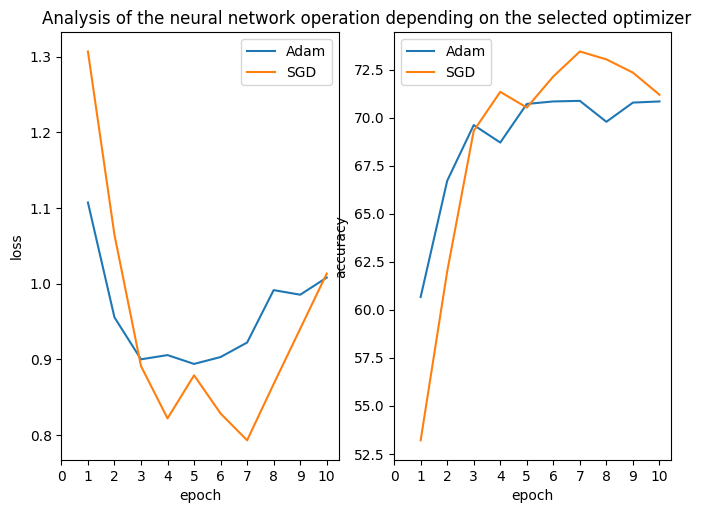

In [29]:
plt.title('Analysis of the neural network operation depending on the selected optimizer')
plt.axis('off')
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.plot(x, loss_mas[0], label = "Adam")
plt.plot(x, loss_mas[1], label = "SGD")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(0, epoch + 1))
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, accuracy_mas[0], label = "Adam")
plt.plot(x, accuracy_mas[1], label = "SGD")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(0, epoch + 1))
plt.legend()
plt.show()

В конце можем закрыть ненужные файлы. И после обучения моделей, можем сохранить их для дальнейшей работы с ними:

In [30]:
f_adam.close()
f_sgd.close()
#сохранение моделей и закрытие файлов
torch.save(model_adam, 'model_adam.pth')
torch.save(model_sgd, 'model_sgd.pth')